## Get imaging frames corresponding to stimulation epochs

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from fish.ephys.ephys import load, estimate_onset, chop_trials

In [3]:
dirs = {}
dirs['ephys'] = '/groups/ahrens/ahrenslab/davis/data/ephys/20170531/5dpf_th1_cochcrxgfap_rgeco_f1_opto_11/5dpf_th1_cochcrxgfap_rgeco_f1_opto_11.10chFlt'

In [15]:
ep_dat = load(dirs['ephys'])
cam_times = estimate_onset(ep_dat[2], threshold=3.7, duration=100)
laser_on = estimate_onset(ep_dat[3], threshold=3.7, duration=400)
laser_off = len(ep_dat[3]) - estimate_onset(ep_dat[3][::-1], threshold=3.7, duration=400)

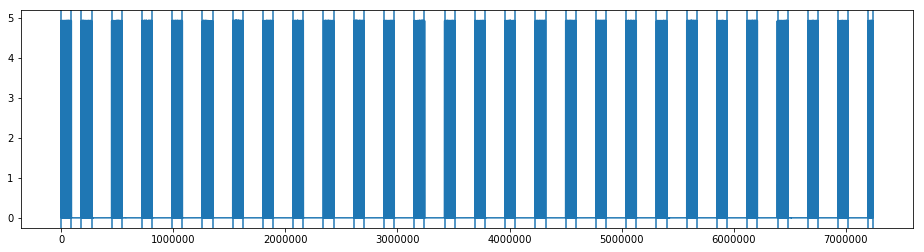

In [16]:
plt.figure(1,(16,4))
plr = np.arange(0, ep_dat.shape[1], 100)
plt.plot(plr, ep_dat[3][plr])
[plt.axvline(l) for l in laser_on];
[plt.axvline(l) for l in laser_off];

Get times when different ROI were stimulated.
Trial timing is sufficiently close to laser timing, so we can just use the time trials started / stopped as a proxy for laser stimulation timing

In [90]:
output = []
events = trials[1.0][0]
for a in events:
    output.append([a-b for b in cam_times])
output = np.array(output)

In [91]:
output.shape

(14, 3601)

In [121]:
ind = 5
len(output[ind][np.where(output[ind] > 0)])

1517

In [182]:
trials = chop_trials(ep_dat[4])
# for each trial onset look for the nearest cam time before the onset.
# for each offset, look for the nearest cam time after offset
def match_cam_time(events, cam, timing):
    from numpy import array, where
    tmp = []
    output = []
    for a in events:
        lags = array([a-b for b in cam])
        before = len(lags[lags > 0]) - 1
        after = before + 1
        
        if (before >= 0) and (after < len(cam)):
            if timing == 'pre':                
                output.append(before)
            if timing == 'post':
                output.append(after)    
    return array(output)

trials_cam = {}

for key, val in trials.items():
    pre = match_cam_time(val[0], cam_times, timing='pre')
    post = match_cam_time(val[1], cam_times, timing='post')
    trials_cam[key] = [pre, post]

In [183]:
trials_cam[2.0]

[array([  62,  207,  643,  789, 1225, 1370, 1807, 1952, 2388, 2533, 2970,
        3115, 3551]),
 array([ 111,  257,  693,  838, 1274, 1420, 1856, 2001, 2437, 2583, 3019,
        3164])]

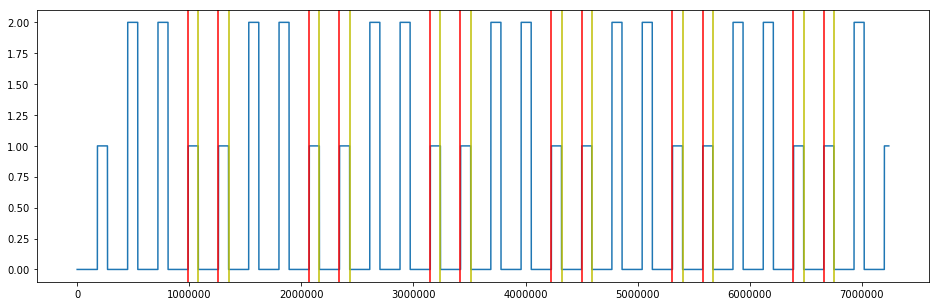

In [184]:
plt.figure(1,(16,5))
plt.plot(ep_dat[4])
#[plt.axvline(c, alpha = .4) for c in cam_times];
[plt.axvline(cam_times[t], color='r') for t in trials_cam[1.0][0]];
[plt.axvline(cam_times[t], color='y') for t in trials_cam[1.0][1]];